In [24]:
import numpy as np
import pandas as pd
#from pandas.DataFrame import ewm,rolling_mean,rolling_var,rolling_skew,rolling_kurt
import matplotlib as pl
import matplotlib.pyplot as plt

from copy import deepcopy

from random import shuffle

#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#from keras.models import Model, load_model, Sequential
#from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Flatten, Add, LeakyReLU, ReLU, ELU
#from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Lambda, Concatenate, PReLU
#from keras.optimizers import Adam
from keras.utils import to_categorical
#from keras import regularizers
#import keras.backend as K
from pathlib import Path

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from scipy.signal import spectrogram
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import skew, skewtest, linregress,theilslopes, entropy, kurtosis, hmean, iqr
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score

import lightgbm as lgb
#import xgboost as xgb
import joblib
from bayes_opt import BayesianOptimization

import os
from tqdm import tqdm

import collections
import warnings
from operator import gt, lt

#from numba import jit,prange,float64,njit
from timeit import default_timer as timer

#import catboost as cb
#from catboost import CatBoostRegressor

os.environ['KMP_DUPLICATE_LIB_OK']="1"
    
epsilon=1e-15

pd.set_option('display.max_rows', 500)

pd.options.display.max_columns = None
np.set_printoptions(threshold=np.inf)

# pandas doesn't show us all the decimals
pd.options.display.precision = 15

import warnings 
warnings.filterwarnings('ignore')
np.warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

def ennusta(inputfile):


def plot_importance(features,by="importance_split",show_array=False):
    cols = (features[["Feature", "importance_split"]]
            .groupby("Feature")
            .mean()
            .sort_values(by=by, ascending=False)[:200].index)
    best_features = features.loc[features.Feature.isin(cols)]

    plt.figure(figsize=(14,26))
    sns.barplot(x="importance_split", y="Feature", data=best_features.sort_values(by=by,ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png') 
    plt.show()    
    
def metric(x,y):
    return accuracy_score(x, y)

##############################
# Naive Bayesian classifier

def predict_naivebayes(clf,x,classes=True):
    
    y_pred=np.maximum(0,clf.predict(x))

    return y_pred

def drop_columns_with_word(df,words):
    for w in words:
        df = df[df.columns.drop(list(df.filter(regex=w)))]
        
    return df
        
def remove_nans(X):
    #X.values=np.nan_to_num(X.values,copy=False)
    #if (isinstance(X, (np.ndarray, np.generic) )):
    #    X=pd.DataFrame(X)
    
    X=X.replace([np.inf, -np.inf], np.nan)
    ret=pd.DataFrame(data=np.nan_to_num(X.values,copy=True),columns=X.columns,index=X.index)
    #find_nans(ret)
    
    return ret  

def fit_naivebayes_model(num_round,X_train,y_train,X_validation,y_valid,verbose,feat_cols):
    clf = GaussianNB()
    #clf=ComplementNB()
    clf.fit(X_train,y_train)
        
    y_pred=predict_naivebayes(clf,X_validation)
    
    print(y_pred,y_valid)

    valid_mae=metric(y_pred,y_valid)
        
    return clf,valid_mae   

def fit_lgbm(num_round,X_train,y_train,X_validation,y_valid,verbose,feat_cols,fold):
    
    num=max(np.max(y_train),np.max(y_valid))+1
    param = {
         'objective':'multiclass',
         'num_boost_round': 2000,
         'num_leaves':128,
         'max_bin':10,
         'num_class':num,
         'metric': 'multi_logloss',
         'verbose':100,
         'early_stopping_rounds':10,
         'max_depth':8}
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_validation, y_valid, reference=lgb_train)
    evals_result={}
    
    gbm = lgb.train(param,
            lgb_train,
            verbose_eval=0,
            valid_sets=lgb_eval)
    #bst = cb.lgb_bestmodel
    #print('The best iteration {f} and score {s}'.format(f=cb.best_iteration,s=cb.best_score))
    y_pred=np.argmax(gbm.predict(X_validation),axis=1)
    
    #display(y_pred,y_valid)

    valid_mae=metric(y_pred,y_valid)
    #valid_mae2=mae_score(y_pred2,y_valid)
    
    fold_importance_df=pd.DataFrame()
    bst=gbm # models_bst[0]
    fold_importance_df['importance_gain']=bst.feature_importance(importance_type='gain') # booster_.
    fold_importance_df['importance_split']=bst.feature_importance(importance_type='split') # booster_.
    fold_importance_df['Feature']=feat_cols
    fold_importance_df["fold"] = fold + 1
    fold_importance_df=fold_importance_df.sort_values(by='importance_split',ascending=False)    
    
    return gbm,valid_mae,y_pred,fold_importance_df

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Oikea puolue',
           xlabel='Ennustettu puolue')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def get_cols():
    cols=['vaalipiiri', 'puolue', 'Valintatieto (0=ei valita 1=valitaan 2=varalla)', 
          'Suomen pitää olla edelläkävijä ilmastonmuutoksen vastaisessa taistelussa vaikka se aiheuttaisi suomalaisille kustannuksia.', 
          'Suomen ei pidä kiirehtiä kieltämään uusien bensa- ja dieselautojen myyntiä.', 
          'Valtion pitää ohjata suomalaiset syömään vähemmän lihaa esimerkiksi verotuksen avulla.', 
          'Metsiä hakataan Suomessa liikaa.', 
          'Kun valtion menoja ja tuloja tasapainotetaan se on tehtävä mieluummin menoja karsimalla kuin veroja kiristämällä.', 
          'Sosiaaliturvaa tulee kehittää niin että osa nykyisistä tuista korvataan kaikille työikäisille maksettavalla vastikkeettomalla perustulolla.', 'Euron ulkopuolella Suomi pärjäisi paremmin.', 'Sosiaali- ja terveyspalvelut on tuotettava ensisijaisesti julkisina palveluina.', 'Vanhustenhoidon ulkoistamista yksityisille toimijoille tulee lisätä.', 'Parantumattomasti sairaalla on oltava oikeus eutanasiaan.', 'Sukupuolen korjaamisen tulee olla mahdollista myös alle 18-vuotiaille.', 'Viinit ja vahvat oluet pitää saada ruokakauppoihin.', 'Energiajuomien myyminen alle 15-vuotiaille on kiellettävä.', 'Nuuskan purutupakan ja nenänuuskan matkustajatuonnin raja lasketaan 1000 grammasta 100 grammaan vuorokaudessa.', 'Perhevapaita pitää uudistaa niin että vapaat jakautuvat tasan vanhempien kesken.', 'Oppivelvollisuus pitää ulottaa myös ammatilliseen koulutukseen ja lukioon.', 'Koulujen kesälomia tulee siirtää kahdella viikolla niin että ne alkavat kesäkuun puolivälissä ja päättyvät elokuun lopulla.', 'Korkeakoulujen määrää pitää vähentää ja vapautuneet voimavarat käyttää huippuopetukseen ja -tutkimukseen.', 'Maahanmuuttajien määrän kasvu on lisännyt turvattomuutta Suomessa.', 'Sosiaali- ja terveyspalveluiden rahoittaminen vaatii työperäisen maahanmuuton merkittävää lisäämistä.', 'Nato-jäsenyys vahvistaisi Suomen turvallisuuspoliittista asemaa.', 'Vihapuhe tulee määritellä ja asettaa rangaistavaksi rikoslaissa.', 'Perinteiset arvot ovat hyvän elämän perusta.', 'Suomessa tarvitaan nyt koviakin keinoja järjestyksen ja tavallisten ihmisten puolustamiseksi.', 'On oikein että yhteiskunnassa jotkut ryhmät ovat paremmassa asemassa kuin toiset. ', 'Suomen lakien pitäisi nykyistä vapaammin antaa ihmisten tehdä omat ratkaisunsa ja kantaa niiden seuraukset.', 'Poliitikon velvollisuus on ennen kaikkea ajaa omien äänestäjiensä etuja.', 'On olemassa pyhiä tai muuten yksilöä suurempia asioita joita täytyy puolustaa silloinkin kun se vaatii omien etujen uhraamista.', 'On oikein nähdä vaivaa sen eteen ettei vahingossakaan loukkaa toista.', 'Kuinka vanha olet?']

Populating the interactive namespace from numpy and matplotlib


In [28]:
def ennusta(inputfile):
    source = pd.read_hdf(inputfile,'table')
    print(source.shape)

    obj_cols = source.loc[:, source.dtypes == object]
    conv = obj_cols.apply(pd.to_numeric, errors = 'coerce')
    
    conv[['vaalipiiri','puolue']]=source[['vaalipiiri','puolue']].astype(str)
    #conv[['vaalipiiri','puolue']].astype(str)
    source=conv.copy()
    source=remove_nans(source)
    source=source.dropna(how='all',axis=1)
    source=source.fillna(value=0)
    
    use_cols=source.columns
    
    cols=[]
    for col in source.columns:
        cols.append(col.replace(',', '').replace('\n', '').replace('\r', ''))
    
    use_cols=cols
    
    source.columns=use_cols
        
    Uusimaa = source #[source['vaalipiiri']=='Uudenmaan vaalipiiri']
    
    Uusimaa=Uusimaa[use_cols]
    tiputa=['Uusimaa','Ahvenanmaa','Helsinki','Pirkanmaa','Varsinais-Suomi','Häme','Oulun vaalipiiri',
            'Savo-Karjala','Keski-Suomi','Vaasa','Lappi','Kaakkois-Suomi','Satakunta']
    Uusimaa = drop_columns_with_word(Uusimaa,tiputa)
    
    y=pd.DataFrame(Uusimaa['puolue'].astype(str),columns=['puolue'])
    #y=pd.DataFrame(Uusimaa['Valintatieto (0=ei valita 1=valitaan 2=varalla)'].astype(str),columns=['puolue'])
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X=Uusimaa[Uusimaa.columns.difference(['puolue','vaalipiiri','Kuinka vanha olet?','Valintatieto (0=ei valita 1=valitaan 2=varalla)','Sukupuolesi','Äidinkielesi'])].astype(int)
    #display(X)
    
    n_classes=len(unique_labels(y))
    classes=encoder.inverse_transform(np.arange(n_classes))
    
    kf=KFold(5,shuffle=True)
        
    fold=1
    clf_safe=[]
    y_test_safe=[]
    y_pred_safe=[]
    score_safe=[]
    fold_importance_safe=[]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y[train_index], y[test_index]    
        
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)    
                                            
        #clf,score=fit_naivebayes_model(1,X_train,y_train,X_test,y_test,1,[])
        #print(score)

        clf,score,y_pred,fold_importance_df=fit_lgbm(100,X_train,y_train,X_test,y_test,1,X.columns,fold)
        print('Fold {f}: score {s}'.format(f=fold,s=score))
        fold=fold+1
        
        score_safe.append(score)
        clf_safe.append(clf)
        y_test_safe.append(y_test)
        y_pred_safe.append(y_pred)
        fold_importance_safe.append(fold_importance_df)

    
    y_test=np.concatenate(y_test_safe).ravel()
    y_pred=np.concatenate(y_pred_safe).ravel()
    
    return y_test,y_pred,fold_importance_safe,classes



# Luokittelija Ylen vaalikoneen kysymyksille

Yle jakaa vaalikoneen kysymyksiä vapaasti. Aineiston avulla voi yrittää esimerkiksi ymmärtää, miten yhtenäisiä puolueiden 
ehdokkaiden vastaukset ovat. Sen avulla voi myös yrittää ennustaa kysymyksistä sen, mitä puoluetta vastaaja edustaa.

Tämä on perinteinen koneoppimisen luokittelutehtävä, ja siihen tunnetaan toimivia välineitä. Käytetään tässä
tutkimuksessa Microsoftin LightGBM-luokittelijaa, joka on nk Boostattu puu-rakenteinen algoritmi. Sitä on käytetty
menestyksellä esimerkiksi Kagglen koneoppimiskilpailuissa.




## Rakennetaan luokittelija

Koodi luokittalijalle on saatavan https://ajtanskanen.github.io/vaaliluokittelija/ Ajetaan aluksi viisinkertainen luokitus aineistolle, josta käytetään ainoastaan numeerisia vastauksia kysymyksiin. 

Malli sovitetaan niin, että sekoitetaan aineisto ja otetaan siitä 80 % opetusaineistoksi ja 20 % testiaineistoksi. Toistetaan sama viisi kertaa, jolloin koko aineisto käydään läpi, ja saadaan opetusaineiston ulkopuolisista ennusteista koottua ennuste jokaiselle ehdokkaalle.

In [29]:
y_test,y_pred,fold_importance_safe,classes=ennusta('avoindata.h5')


(2437, 212)
Fold 1: score 0.5717213114754098
Fold 2: score 0.5737704918032787
Fold 3: score 0.5893223819301848
Fold 4: score 0.5626283367556468
Fold 5: score 0.5790554414784395


Malli ennustaa 56 - 59 prosentin tarkkuudella ehdokkaan puolueen, ehdokkaan vastausten perusteella. Kun aineistossa on 21 puoluetta, on tarkkuus kohtuullinen.

## Menevätkös puolueet sekaisin?

Kun malli on sovitettu, testataan miten hyvin se toimii. Katsotaan ensin, menevätkö puolueet sekaisin vastausten perusteella.

Confusion matrix, without normalization


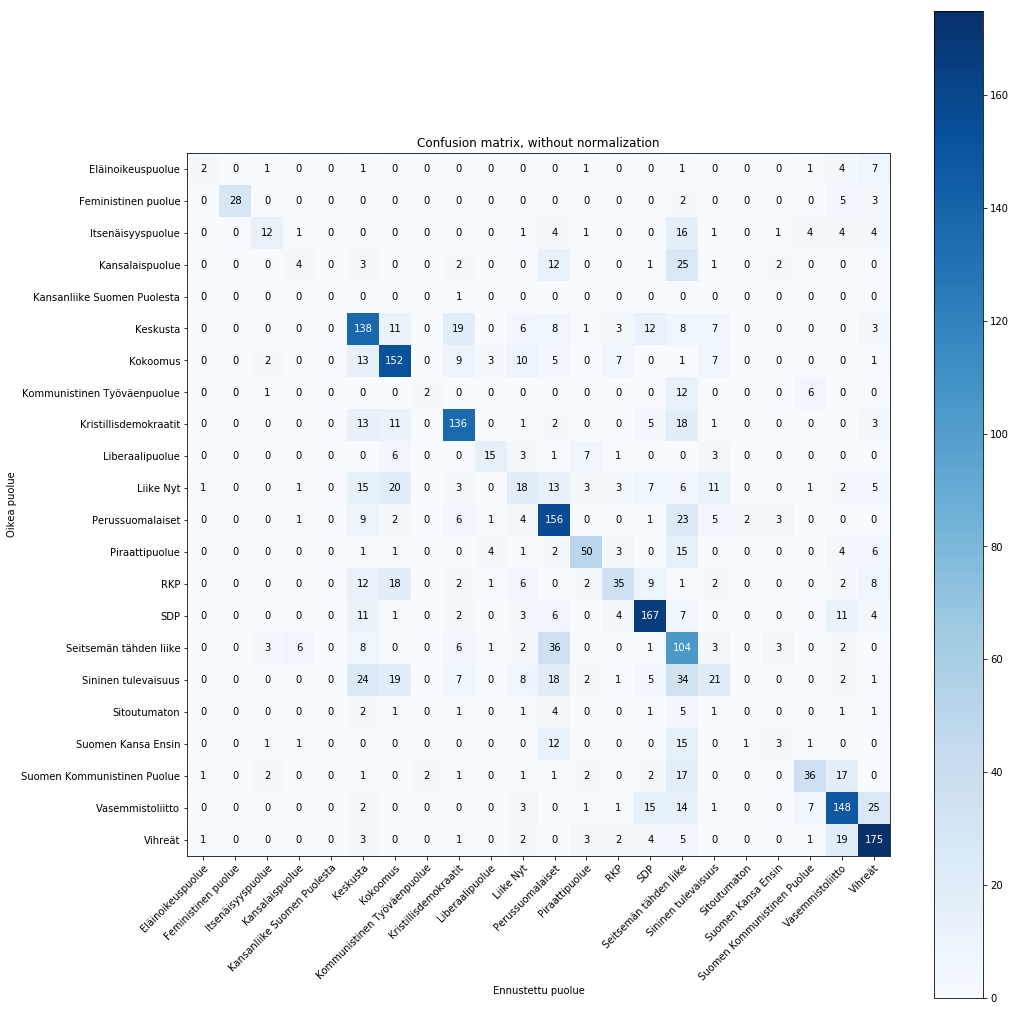

In [33]:


plot_confusion_matrix(y_test, y_pred, classes=classes, normalize=False,
                  title='Confusion matrix, without normalization')


Ja sama suhteellisilla osuuksilla.

In [ ]:

plot_confusion_matrix(y_test, y_pred, classes=classes, normalize=True,
                  title='Confusion matrix, normalisoituna')


## Tärkeimmät kysymykset

In [ ]:

plot_importance(fold_importance_safe,by="importance_split")